In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()
import pystan
import arviz as az
from scipy.integrate import odeint

seed = 1111

## Define parameters

In [2]:
current_region = 'Oslo'

#############################################################################
D_e = 3 / 7
D_p = 2 / 7
D_i = 5 / 7

r = 0.4

r_a = 0.1 
r_p = 1.25 

#############################################################################
# LFO
M = 3
L = 10

## Import dataframes

In [3]:
df_regions = pd.DataFrame(pd.read_csv('~/Documents/Corona/Dataframes/df_regions.csv'))
df_regions

,region,population,critical_week_start_infections,critical_week_end_infections
0,Pirkanmaa,515095,2020-09-27,2020-11-29
1,Uusimaa,1671000,2020-09-13,2020-11-15
2,Southwest Finland,478582,2020-09-27,2020-11-29
3,Skåne County,1340000,2020-10-11,2020-12-13
4,Stockholm County,2344000,2020-09-13,2020-11-15
5,Västra Götaland County,1710000,2020-10-18,2020-12-20
6,Oslo,634293,2020-10-18,2020-12-20
7,Vestland,636500,2020-10-18,2020-12-20
8,Viken,1213354,2020-10-18,2020-12-20


In [4]:
df_investigated_time_period = pd.DataFrame(pd.read_csv('~/Documents/Corona/Dataframes/df_investigated_time_period.csv'))
df_investigated_time_period

,region,last_sunday_of_the_week,infections_week_sum,traffic_retail_average,traffic_supermarket_average,traffic_parks_average,traffic_transit_stations_average,traffic_workplaces_average,traffic_residential_average
0,Pirkanmaa,2020-09-27,39,0.00,0.00,0.00,0.00,0.00,0.00
1,Pirkanmaa,2020-10-04,94,0.01,0.01,-0.31,-0.03,0.00,0.01
2,Pirkanmaa,2020-10-11,68,-0.02,-0.01,-0.57,-0.06,0.00,0.02
3,Pirkanmaa,2020-10-18,62,0.00,-0.02,-0.36,-0.11,-0.19,0.04
4,Pirkanmaa,2020-10-25,94,-0.03,-0.02,-0.86,-0.08,0.00,0.04
...,...,...,...,...,...,...,...,...,...
85,Viken,2020-11-22,1348,-0.12,-0.05,-0.53,-0.15,-0.08,0.06
86,Viken,2020-11-29,1118,-0.04,-0.02,-0.52,-0.15,-0.08,0.06
87,Viken,2020-12-06,1203,-0.04,0.07,-0.70,-0.15,-0.06,0.06
88,Viken,2020-12-13,1143,0.01,0.15,-0.75,-0.14,-0.05,0.05


## Quantities which directly come from dataframes

In [5]:
N = df_regions[(df_regions['region'] == current_region)]['population'].tolist()[0]

df_current = df_investigated_time_period[(df_investigated_time_period['region'] == current_region)]

# Initialize the states
inf0 = df_current['infections_week_sum'].tolist()[0] # Weekly infections during first week
P0 = int(inf0 * D_p)
E0 = int( (1/r) * (D_e / D_p) * P0)
I0 = int((1-r) * (D_i / D_e) * E0)
A0 = int(r * (D_i / D_e) * E0)
R0 = 0
S0 = N - I0 - P0 - A0 - E0 - R0
y0 = [S0, E0, A0, P0, I0, R0]

df_current = df_current.iloc[1:] # The first row can be now removed 

num_data_points = df_current.shape[0]

infections = df_current['infections_week_sum'].tolist()
traffic_retail = df_current['traffic_retail_average'].tolist()
traffic_supermarket = df_current['traffic_supermarket_average'].tolist()
traffic_parks = df_current['traffic_parks_average'].tolist()
traffic_transit_stations = df_current['traffic_transit_stations_average'].tolist()
traffic_workplaces = df_current['traffic_workplaces_average'].tolist()
traffic_residential = df_current['traffic_residential_average'].tolist()

traffic_components = [traffic_retail, traffic_supermarket, traffic_parks,
                      traffic_transit_stations, traffic_workplaces, traffic_residential]
traffic_descriptions = ["Retail traffic", "Supermarket traffic", "Park traffic",
                        "Transit station traffic", "Workplace traffic", "Residential traffic"]
traffic_colors = ["tab:purple", "blue", "green", "red", "tab:orange", "y" ]

date_interval = df_current['last_sunday_of_the_week'].tolist()

## Plot the analyzed interval

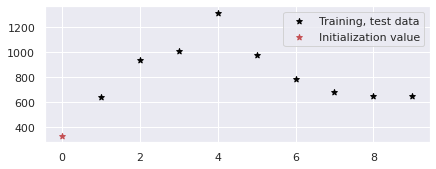

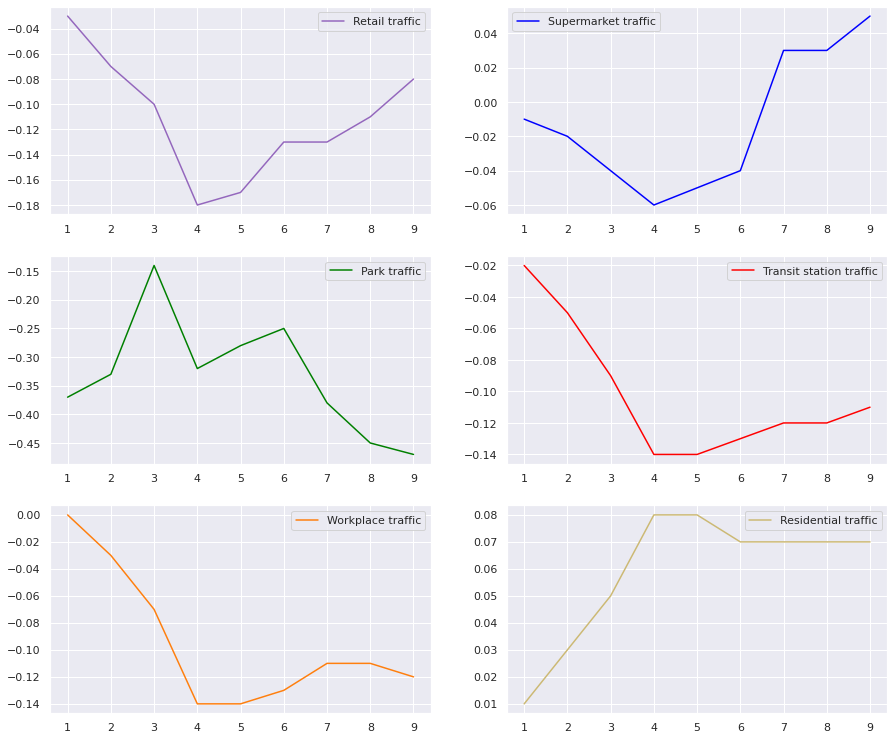

In [6]:
fig1, ax1 = plt.subplots(1,figsize=(6.9,2.5))
ax1.scatter(range(1, 1 + num_data_points), infections, marker = '*', color='black', label = 'Training, test data')
ax1.scatter(0, inf0, marker = '*', color='r', label = 'Initialization value')
ax1.legend()

plot_rows = 3
plot_columns = 2

fig, ax = plt.subplots(plot_rows, plot_columns, figsize=(15,13))

for i in range(plot_rows):
    for j in range(plot_columns):
        
        ax[i, j].plot(range(1, 1 + num_data_points), traffic_components[i*plot_columns + j],
                      traffic_colors[i*plot_columns + j], label = traffic_descriptions[i*plot_columns + j]) 
        ax[i, j].legend()


plt.show()

## Run the model, smoothening

### Initialization

In [8]:
sm = pystan.StanModel(file="./SEAPIR_Model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_feedd427e14d26e66c285aa2bd01233f NOW.


In [9]:
seapir_data = {
    "prior_means":[0,0],
    "prior_stds":[10,10],
    "n_training": num_data_points,
    "n_test": 0,
    "y0": y0,

    "t0": 0,
    "t_training": list(range(1, 1+num_data_points)),
    "t_test": np.empty(0),
    "N": N,

    "D_e": D_e,
    "D_p": D_p,
    "D_i": D_i,
    "r": r,
    "r_a": r_a,
    "r_p": r_p,

    "infections": infections,
    "infections_pred": np.empty(0).astype(int),
    "traffic": traffic_retail,
    "traffic_pred": np.empty(0),
}

### Fit the model for each traffic component 

In [10]:
smoothening_fits = [] # fits of different traffic components
smoothening_log_likelihoods = []

def smoothening_fits_all_traffic_components():
    all_fits = []
    log_likelihoods = []
    
    for i in range(6):
        current_traffic = traffic_components[i]
        print("Currently plotting: " + traffic_descriptions[i])
        
        seapir_data['traffic'] = current_traffic
        
        fit = sm.sampling(seapir_data, seed=seed)
        all_fits.append(fit)
        
        loglik_exact = np.empty(4000)
        samples = fit.extract(permuted=True)
        loglik_exact[:] = samples["log_lik_training"].ravel()
        log_likelihoods.append(np.mean(loglik_exact))
    
    return all_fits, log_likelihoods
        
smoothening_fits, smoothening_log_likelihoods = smoothening_fits_all_traffic_components()

Currently plotting: Retail traffic


Currently plotting: Supermarket traffic


Currently plotting: Park traffic


Currently plotting: Transit station traffic


Currently plotting: Workplace traffic


Currently plotting: Residential traffic


### Taking a closer look at values of a specific fit 

In [11]:
# f.e. 3 corresponds transit station traffic
#print(smoothening_fits[3])

### Plots

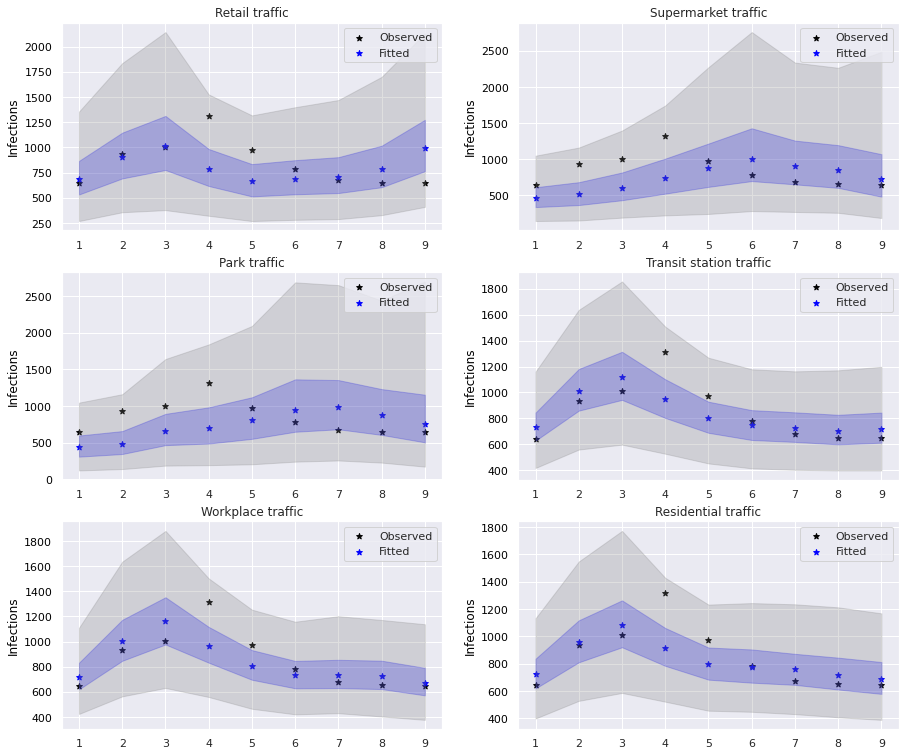

In [12]:
def plot_smoothening_plots_all(smoothening_fits):
   
    fig, ax1 = plt.subplots(3, 2, figsize=(15,13))
    
    for i in range(plot_rows):
        for j in range(plot_columns):

            k = i*plot_columns + j
            
            current_traffic = traffic_components[k]
            current_description = traffic_descriptions[k]
            current_color = traffic_colors[k]
            current_fit = smoothening_fits[k]

            # First plot
            ret = np.empty((5, num_data_points))
            ret[0, :] = np.quantile(current_fit['infections_hat'], 0.5, axis=0)
            ret[1, :] = np.quantile(current_fit['infections_hat'], 0.25, axis=0)
            ret[2, :] = np.quantile(current_fit['infections_hat'], 0.75, axis=0)
            ret[3, :] = np.quantile(current_fit['infections_hat'], 0.025, axis=0)
            ret[4, :] = np.quantile(current_fit['infections_hat'], 0.975, axis=0)


            color = 'black'
            ax1[i, j].set_ylabel('Infections', color='black')
            ax1[i, j].scatter(range(1,num_data_points+1), infections, marker='*', label='Observed', color='black')

            ax1[i, j].scatter(range(1,num_data_points+1), ret[0, :], marker='*', label='Fitted', color='blue')

            ax1[i, j].fill_between(range(1,num_data_points+1), ret[1, :], ret[2, :], label='50% -interval',color='blue', alpha=0.25)
            ax1[i, j].fill_between(range(1,num_data_points+1), ret[3, :], ret[4, :], label='95% -interval',color='grey', alpha=0.25)

            ax1[i, j].tick_params(axis='y', labelcolor=color)

            handles, labels = ax1[i, 0].get_legend_handles_labels()
            order = [0,1]
            ax1[i, j].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            ax1[i, j].title.set_text(current_description)
    
    
plot_smoothening_plots_all(smoothening_fits)

### Intervals for $c_1$ and $c_2$

In [13]:
for c in range(6):
    current_fit = smoothening_fits[c]
    
    constant_low = round(np.quantile(current_fit['constant'], 0.025, axis=0), 2)
    constant_high = round(np.quantile(current_fit['constant'], 0.975, axis=0), 2)
    
    slope_low = round(np.quantile(current_fit['traffic_slope'], 0.025, axis=0), 2)
    slope_high = round(np.quantile(current_fit['traffic_slope'], 0.975, axis=0), 2)
    
    print(traffic_descriptions[c])
    print("Constant, 95-interval: [" + str(constant_low) + ", " + str(constant_high) +"]")
    print("Traffic slope, 95-interval: [" + str(slope_low) + ", " + str(slope_high) +"]")
    print("-------------------------------------------")

Retail traffic
Constant, 95-interval: [1.93, 3.24]
Traffic slope, 95-interval: [2.16, 13.53]
-------------------------------------------
Supermarket traffic
Constant, 95-interval: [1.38, 1.85]
Traffic slope, 95-interval: [-13.74, 4.59]
-------------------------------------------
Park traffic
Constant, 95-interval: [0.76, 3.74]
Traffic slope, 95-interval: [-3.1, 6.42]
-------------------------------------------
Transit station traffic
Constant, 95-interval: [2.19, 3.0]
Traffic slope, 95-interval: [5.49, 13.46]
-------------------------------------------
Workplace traffic
Constant, 95-interval: [2.09, 2.68]
Traffic slope, 95-interval: [4.94, 11.24]
-------------------------------------------
Residential traffic
Constant, 95-interval: [2.11, 2.88]
Traffic slope, 95-interval: [-21.7, -7.99]
-------------------------------------------


### Log likelihood

In [14]:
print(smoothening_log_likelihoods)

[-63.21556740552117, -66.26657849672739, -66.65511540316353, -58.6752592050886, -58.39935073452849, -58.672188250600925]


## Leave future out

### Initialization

In [15]:
M = 2 # The last data points
L = 5 # this should be defined automatically

num_lfo_loops = num_data_points - L - M + 1

### Fit the model for each traffic component 

In [16]:
lfo_fits = []

def _all_traffic_components(i, M):
    all_fits = []
    
    for j in range(6):
        current_traffic = traffic_components[j]
        print("Currently plotting: " + traffic_descriptions[j])
        
        # Update data for LFO model
        seapir_data_lfo = seapir_data.copy()
        seapir_data_lfo["n_training"]   = i
        seapir_data_lfo["n_test"]       = M
        seapir_data_lfo["t_test"]       = seapir_data["t_training"][i:i+M]
        seapir_data_lfo["t_training"]   = seapir_data["t_training"][:i]
        seapir_data_lfo["traffic_pred"] = current_traffic[i:i+M]
        seapir_data_lfo["traffic"]      = current_traffic[:i]
        seapir_data_lfo["infections_pred"]  = seapir_data["infections"][i:i+M]
        seapir_data_lfo["infections"]   = seapir_data["infections"][:i]

        fit = sm.sampling(seapir_data_lfo)
        all_fits.append(fit)
        
        irhat = fit.summary()['summary_colnames']
        irhat = irhat.index("Rhat")
        irhat = fit.summary()["summary"][:, irhat]
        print("Biggest r-hat-value of the current loop:")
        print(np.nanmax(irhat))
        print("----------------------")

        
    return all_fits 

for i in range(L, num_data_points - M + 1):

    lfo_fits_current = _all_traffic_components(i, M)
    
    lfo_fits.append(lfo_fits_current)

Currently plotting: Retail traffic


Biggest r-hat-value of the current loop:
1.007336644396156
----------------------
Currently plotting: Supermarket traffic


Biggest r-hat-value of the current loop:
1.010628248808756
----------------------
Currently plotting: Park traffic


Biggest r-hat-value of the current loop:
1.0247570973020144
----------------------
Currently plotting: Transit station traffic


Biggest r-hat-value of the current loop:
1.0549187911057332
----------------------
Currently plotting: Workplace traffic


Biggest r-hat-value of the current loop:
1.0089061166261455
----------------------
Currently plotting: Residential traffic


Biggest r-hat-value of the current loop:
1.032946789900185
----------------------
Currently plotting: Retail traffic


Biggest r-hat-value of the current loop:
1.0062628060859546
----------------------
Currently plotting: Supermarket traffic


Biggest r-hat-value of the current loop:
1.0114289628676163
----------------------
Currently plotting: Park traffic


Biggest r-hat-value of the current loop:
1.017923091203357
----------------------
Currently plotting: Transit station traffic


Biggest r-hat-value of the current loop:
1.0043340521945936
----------------------
Currently plotting: Workplace traffic


Biggest r-hat-value of the current loop:
1.0080634293604507
----------------------
Currently plotting: Residential traffic


Biggest r-hat-value of the current loop:
1.0060482588017967
----------------------
Currently plotting: Retail traffic
Biggest r-hat-value of the current loop:
1.0028833633389977
----------------------
Currently plotting: Supermarket traffic
Biggest r-hat-value of the current loop:
1.0052082221632501
----------------------
Currently plotting: Park traffic


Biggest r-hat-value of the current loop:
1.2756387234905182
----------------------
Currently plotting: Transit station traffic


Biggest r-hat-value of the current loop:
1.0077126060144908
----------------------
Currently plotting: Workplace traffic


Biggest r-hat-value of the current loop:
1.0052301792951155
----------------------
Currently plotting: Residential traffic


Biggest r-hat-value of the current loop:
1.0143938792503278
----------------------


### Taking a closer look at values of a specific fit 

In [17]:
print(lfo_fits[2][3]) # f.e. [0][3] corresponds transit station traffic when L=5

Inference for Stan model: anon_model_feedd427e14d26e66c285aa2bd01233f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
constant            2.52  6.9e-3   0.23   2.07   2.37   2.52   2.66   2.96   1074   1.01
traffic_slope       8.39    0.07   2.39    3.5   6.91   8.44   9.94   13.1   1069   1.01
phi_inv             0.07  1.8e-3   0.06   0.02   0.04   0.06   0.09   0.24   1108    1.0
phi                21.67    0.43  14.26   4.23  11.16  18.08  28.35  60.33   1122    1.0
traffic_coeff[1]    2.52  6.9e-3   0.23   2.07   2.37   2.52   2.66   2.96   1074   1.01
traffic_coeff[2]    8.39    0.07   2.39    3.5   6.91   8.44   9.94   13.1   1069   1.01
y[1,1]             6.3e5    4.23 139.52  6.3e5  6.3e5  6.3e5  6.3e5  6.3e5   1089   1.01
y[2,1]             6.3e5   11.91 396.01  6.3e5  6.3e5  6.3e5  6.3e5  6.3e5   1105   1.01
y[3,1]    

### Plots

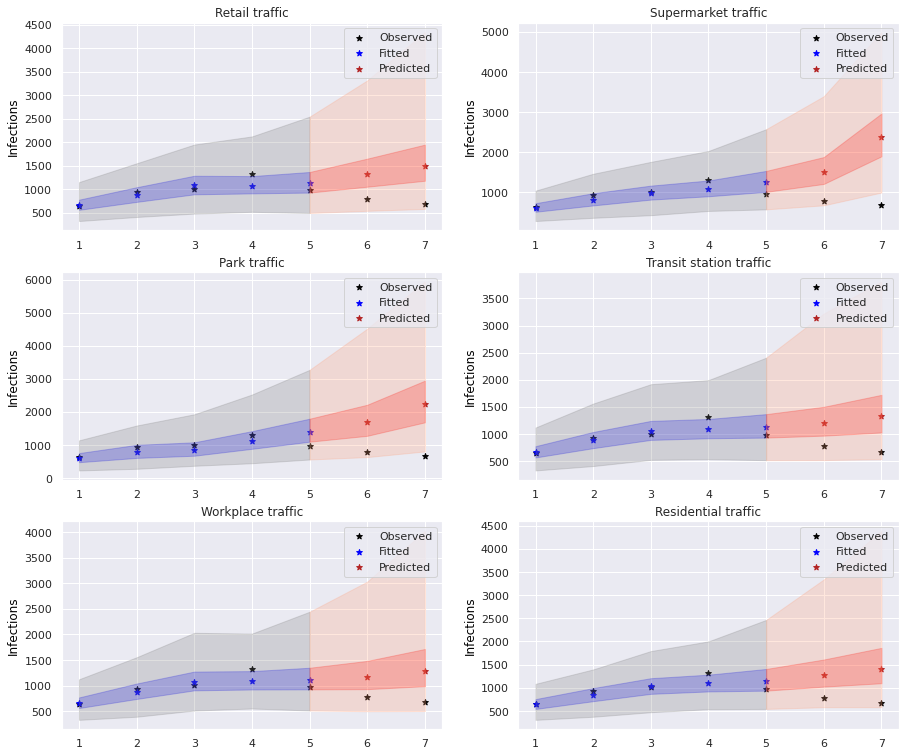

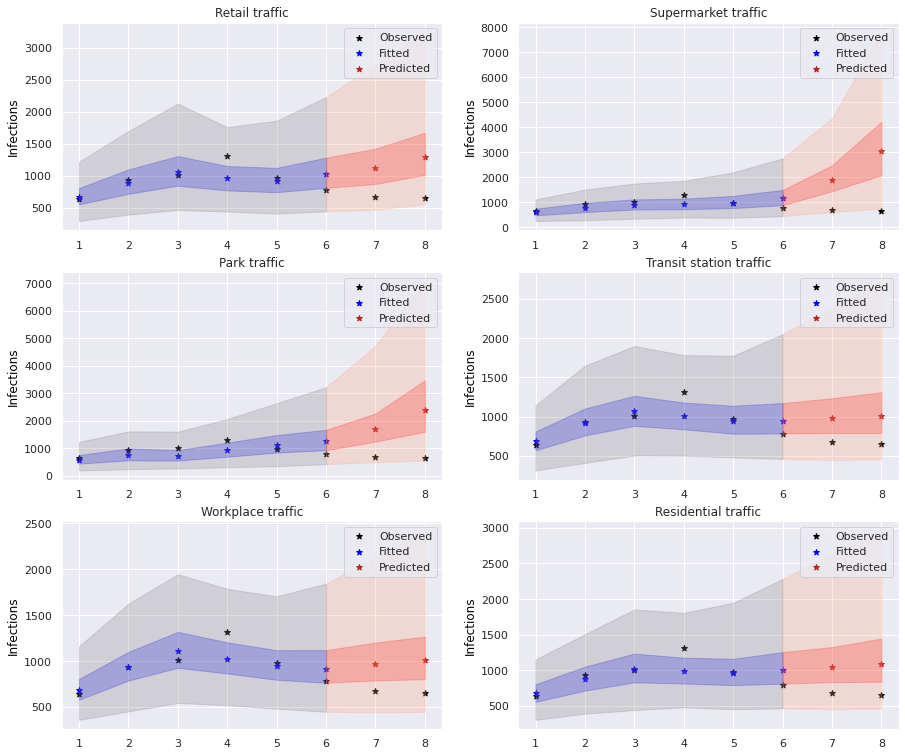

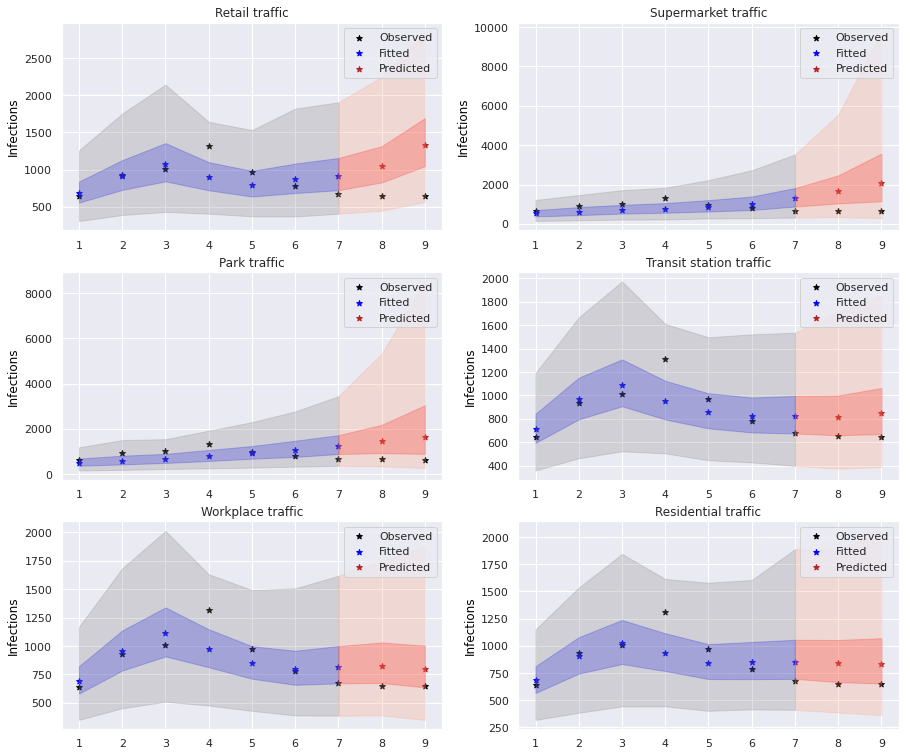

In [18]:
def plot_smoothening_plots_all_pred(lfo_fits, i, M):
    
    fig, ax1 = plt.subplots(3, 2, figsize=(15,13))
    #fig.suptitle('Training data, length: ' + str(training_points), fontsize=16)

    
    for j1 in range(plot_rows):
        for j2 in range(plot_columns):
            
            k = j1*plot_columns + j2

            current_traffic = traffic_components[k]
            current_description = traffic_descriptions[k]
            current_color = traffic_colors[k]
            current_fit = lfo_fits[k]

            # First plot
            ret = np.empty((5, i + M))
            ret[0, :] = np.nanquantile(current_fit['infections_hat'], 0.5, axis=0)
            ret[1, :] = np.nanquantile(current_fit['infections_hat'], 0.25, axis=0)
            ret[2, :] = np.nanquantile(current_fit['infections_hat'], 0.75, axis=0)
            ret[3, :] = np.nanquantile(current_fit['infections_hat'], 0.025, axis=0)
            ret[4, :] = np.nanquantile(current_fit['infections_hat'], 0.975, axis=0)

            color = 'black'
            ax1[j1,j2].set_ylabel('Infections', color='black')
            ax1[j1,j2].scatter(range(1,i+M+1), infections[0:i + M], marker='*', label='Observed', color='black')

            # Draw the test data values
            ax1[j1,j2].scatter(range(1,i+1), ret[0, 0:i], marker='*', label='Fitted', color='blue')
            ax1[j1,j2].fill_between(range(1,i+1), ret[1, 0:i], ret[2, 0:i], label='50% -interval',color='blue', alpha=0.25)
            ax1[j1,j2].fill_between(range(1,i+1), ret[3, 0:i], ret[4, 0:i], label='95% -interval',color='grey', alpha=0.25)

            # Draw the validation data values
            ax1[j1,j2].scatter(range(i+1,i+M+1), ret[0, i:i+M], marker='*', label='Predicted', color='firebrick')
            ax1[j1,j2].fill_between(range(i,i+M+1), ret[1, i-1:i+M], ret[2, i-1:i+M], label='50% -interval',color='red', alpha=0.25)
            ax1[j1,j2].fill_between(range(i,i+M+1), ret[3, i-1:i+M], ret[4, i-1:i+M], label='95% -interval',color='lightsalmon', alpha=0.25)

            handles, labels = ax1[j1, 0].get_legend_handles_labels()
            order = [0,1,4]
            ax1[j1, 0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            ax1[j1, 1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            ax1[j1, j2].title.set_text(current_description)



for i in range(L, L + M + 1):
        
    plot_smoothening_plots_all_pred(lfo_fits[i-L], i, M)


### Intervals for $c_1$ and $c_2$

In [19]:
for c in range(6):
    for j in range(num_lfo_loops):

        current_fit = lfo_fits[j][c]

        constant_low = round(np.quantile(current_fit['constant'], 0.025, axis=0), 2)
        constant_high = round(np.quantile(current_fit['constant'], 0.975, axis=0), 2)

        slope_low = round(np.quantile(current_fit['traffic_slope'], 0.025, axis=0), 2)
        slope_high = round(np.quantile(current_fit['traffic_slope'], 0.975, axis=0), 2)

        print(traffic_descriptions[c] + ", i=" + str(L + j))
        print("Constant, 95-interval: [" + str(constant_low) + ", " + str(constant_high) +"]")
        print("Traffic slope, 95-interval: [" + str(slope_low) + ", " + str(slope_high) +"]")
        print("-------------------------------------------")
        
    print("-------------------------------------------")
    print("-------------------------------------------")

Retail traffic, i=5
Constant, 95-interval: [1.69, 2.93]
Traffic slope, 95-interval: [-2.62, 9.9]
-------------------------------------------
Retail traffic, i=6
Constant, 95-interval: [1.77, 3.09]
Traffic slope, 95-interval: [-0.59, 11.68]
-------------------------------------------
Retail traffic, i=7
Constant, 95-interval: [1.91, 3.15]
Traffic slope, 95-interval: [1.37, 12.45]
-------------------------------------------
-------------------------------------------
-------------------------------------------
Supermarket traffic, i=5
Constant, 95-interval: [1.69, 2.58]
Traffic slope, 95-interval: [-7.27, 19.78]
-------------------------------------------
Supermarket traffic, i=6
Constant, 95-interval: [1.62, 2.62]
Traffic slope, 95-interval: [-6.6, 22.69]
-------------------------------------------
Supermarket traffic, i=7
Constant, 95-interval: [1.4, 2.4]
Traffic slope, 95-interval: [-11.11, 18.0]
-------------------------------------------
-------------------------------------------
-

### Log likelihood

In [20]:
def lfo(fits):
    lfos = [0,0,0,0,0,0]
    
    for c in range(6):
        for j in range(num_lfo_loops):
        
            fit = fits[j][c]

            loglik_exact = np.empty(4000)
            samples = fit.extract(permuted=True)
            loglik_exact[:] = samples["log_lik_pred"].ravel()

            lfos[c] = lfos[c] + np.log(np.nanmean(np.exp(loglik_exact)))
        
    return lfos
        
lfos = lfo(lfo_fits)

print(lfos)

[-45.32916688464874, -50.03170497603422, -48.31242492823998, -41.16847260761277, -40.90819453898166, -41.868212456749845]
